In [2]:
#!/usr/bin/env julia
# =============================================================================
# Full-model uSPAC calibration against tower LE using EKP
# Parameters (8 total):
#   θ = [
#     "alpha_R", "beta_R",    # ΠR ~ aridity
#     "alpha_F", "beta_F",    # ΠF ~ aridity
#     "alpha_T", "beta_Ts",   # ΠT ~ sand
#     "alpha_S", "beta_Ss"    # ΠS ~ sand
# ]
# Forward model:
#   Build LandModel with uSPACConductancePi
# =============================================================================

using ClimaLand
using ClimaLand.Domains: Column
using ClimaLand.Canopy
using ClimaLand.Simulations
import ClimaLand.FluxnetSimulations as FluxnetSimulations
import ClimaLand.Parameters as LP
import ClimaLand.LandSimVis as LandSimVis
import ClimaDiagnostics
import ClimaUtilities.TimeManager as TM
import ClimaUtilities.TimeManager: date
import EnsembleKalmanProcesses as EKP
import EnsembleKalmanProcesses.ParameterDistributions as PD
using CairoMakie
CairoMakie.activate!()
using Statistics
using Logging
import Random
using Dates

# ---------------- Helpers ----------------

# This function runs the model and computes diurnal average of latent heat flux
function G(θ::AbstractVector)
    simulation = model(θ)
    lhf = get_lhf(simulation)
    observation =
        Float64.(
            get_diurnal_average(
                lhf,
                simulation.start_date,
                simulation.start_date + Day(20),
                stop_date,
            ),
        )
    return observation
end;

# Helper function: Extract latent heat flux from simulation diagnostics
function get_lhf(simulation)
    return ClimaLand.Diagnostics.diagnostic_as_vectors(
        simulation.diagnostics[1].output_writer,
        "lhf_30m_average",
    )
end;

# Helper function: Compute diurnal average of a variable
function get_diurnal_average(var, start_date, spinup_date, stop_date)
    (times, data) = var
    model_dates = if times isa Vector{DateTime}
        times
    else
        date.(times)
    end
    spinup_idx = findfirst(spinup_date .<= model_dates)
    stop_idx = findlast(model_dates .< stop_date)
    model_dates = model_dates[spinup_idx:stop_idx]
    data = data[spinup_idx:stop_idx]

    hour_of_day = Hour.(model_dates)
    mean_by_hour = [mean(data[hour_of_day .== Hour(i)]) for i in 0:23]
    return mean_by_hour
end;

# ---------------- Configuration and site setup ----------------

# Set random seed for reproducibility and floating point precision
rng_seed = 1234
rng = Random.MersenneTwister(rng_seed)
const FT = Float32

# Initialize land parameters and site configuration.
toml_dict = LP.create_toml_dict(FT)
site_ID = "US-MOz"
site_ID_val = FluxnetSimulations.replace_hyphen(site_ID);

# Get site-specific information: location coordinates, time offset, and sensor height.
(; time_offset, lat, long) =
    FluxnetSimulations.get_location(FT, Val(site_ID_val))
(; atmos_h) = FluxnetSimulations.get_fluxtower_height(FT, Val(site_ID_val));

# Get simulation start and stop dates in UTC; these must be included in the forcing data range Here we calibrate with only two months of data.
start_date = DateTime(2010, 5, 1)
stop_date = DateTime(2010, 7, 1)
Δt = 450.0; # seconds


# ---------------- Domain and forcing setup ----------------

# Create a column domain representing a 2-meter deep soil column with 10 vertical layers.
zmin = FT(-2)  # 2m depth
zmax = FT(0)   # surface
domain = Column(; zlim = (zmin, zmax), nelements = 10, longlat = (long, lat));

# Load prescribed atmospheric and radiative forcing from FLUXNET data
forcing = FluxnetSimulations.prescribed_forcing_fluxnet(
    site_ID,
    lat,
    long,
    time_offset,
    atmos_h,
    start_date,
    toml_dict,
    FT,
);

# Get Leaf Area Index (LAI) data from MODIS satellite observations.
LAI = ClimaLand.Canopy.prescribed_lai_modis(
    domain.space.surface,
    start_date,
    stop_date,
);

# ---------------- Model Setup ---------------


# Parameterization
# θ = [αR, βR, αF, βF, αT, βTs, αS, βSs]
function unpack_params(θ::AbstractVector)
    @assert length(θ) == 8
    αR, βR, αF, βF, αT, βTs, αS, βSs = θ
    return (αR=αR, βR=βR, αF=αF, βF=βF, αT=αT, βTs=βTs, αS=αS, βSs=βSs)
end

# Forward operator: build LandModel with uSPACConductancePi

# Create an integrated land model that couples canopy, snow, soil, and soil CO2 components. 
# This comprehensive model allows us to simulate the full land surface system and its interactions.
function model(θ::AbstractVector)
    # ---- unpack θ into Π-coefficient tuples ----
    pθ = unpack_params(θ)
    ΓR = (FT(pθ.αR),  FT(pθ.βR))     # aridity → ΠR
    ΓF = (FT(pθ.αF),  FT(pθ.βF))     # aridity → ΠF
    ΓT = (FT(pθ.αT),  FT(pθ.βTs))    # sand    → ΠT   (sand-only)
    ΓS = (FT(pθ.αS),  FT(pθ.βSs))    # sand    → ΠS   (sand-only)

    # --- construct Π-group conductance model ---
    uspac_pars = ClimaLand.Canopy.uSPACPiParameters{FT}(;ΓR=ΓR, ΓF=ΓF, ΓT=ΓT, ΓS=ΓS)
    conductance = ClimaLand.Canopy.uSPACConductancePi{FT}(uspac_pars)
    # ^ The model’s update_canopy_conductance! will auto-pull aridity & sand
    #   from p.drivers / p.soil (uspacmodel.jl).

    # ---- build the rest of the LandModel stack ----
    ground = ClimaLand.PrognosticGroundConditions{FT}()
    prognostic_land_components = (:canopy, :snow, :soil, :soilco2)

    canopy_domain  = ClimaLand.Domains.obtain_surface_domain(domain)
    canopy_forcing = (; forcing.atmos, forcing.radiation, ground)

    space    = canopy_domain.space.surface
    defaults = ClimaLand.Canopy.clm_photosynthesis_parameters(space)

    farq_params = FarquharParameters(
        toml_dict;
        is_c3   = defaults.is_c3,
        Vcmax25 = defaults.Vcmax25,
    )
    photosynthesis = FarquharModel{FT}(farq_params)

    canopy = ClimaLand.Canopy.CanopyModel{FT}(
        canopy_domain,
        canopy_forcing,
        LAI,
        toml_dict;
        photosynthesis,
        prognostic_land_components,
        conductance,
    )

    land_model = LandModel{FT}(forcing, LAI, toml_dict, domain, Δt; canopy)

    set_ic! = FluxnetSimulations.make_set_fluxnet_initial_conditions(
        site_ID, start_date, time_offset, land_model,
    )

    output_vars = ["lhf"]
    diagnostics = ClimaLand.default_diagnostics(
        land_model, start_date;
        output_writer = ClimaDiagnostics.Writers.DictWriter(),
        output_vars,
        reduction_period = :halfhourly,
    )

    simulation = Simulations.LandSimulation(
        start_date, stop_date, Second(Δt), land_model;
        set_ic! = set_ic!, updateat = Second(Δt),
        user_callbacks = (), diagnostics = diagnostics,
    )
    solve!(simulation)
    return simulation
end

# ---------------- Experiment Setup ----------------

dataset = FluxnetSimulations.get_comparison_data(site_ID, time_offset)
observations = get_diurnal_average(
    (dataset.UTC_datetime, dataset.lhf),
    start_date,
    start_date + Day(20),
    stop_date,
);

noise_covariance = 0.05 * EKP.I;

# ---------------- Prior Distribution and Calibration Config ----------------

# Set up the prior distribution for the parameter and configure the ensemble Kalman inversion:

# Uninformative priors:
names = [
    "alpha_R", "beta_R",    # ΠR ~ aridity
    "alpha_F", "beta_F",    # ΠF ~ aridity
    "alpha_T", "beta_Ts",   # ΠT ~ sand
    "alpha_S", "beta_Ss"    # ΠS ~ sand
]
priors = PD.ParameterDistribution[
    PD.constrained_gaussian(names[i], 0.0, 0.30, -Inf, Inf) for i in 1:8
]
prior = PD.combine_distributions(priors)

# Weakly informative priors:
# names = [
#     "alpha_R","beta_R",
#     "alpha_F","beta_F",
#     "alpha_T","beta_Ts",
#     "alpha_S","beta_Ss",
# ]

# μ = [
#     1.5, 0.30,   # alpha_R, beta_R
#     2.0, 0.20,   # alpha_F, beta_F
#     1.0, 0.80,   # alpha_T, beta_Ts
#     1.2, 0.50,   # alpha_S, beta_Ss
# ]

# σ = [
#     0.5, 0.20,   # alpha_R, beta_R
#     0.6, 0.20,   # alpha_F, beta_F
#     0.4, 0.40,   # alpha_T, beta_Ts
#     0.4, 0.30,   # alpha_S, beta_Ss
# ]

# lower = [
#     0.2, -0.20,
#     0.3, -0.20,
#     0.1, -0.50,
#     0.1, -0.50,
# ]

# upper = [
#     5.0, 1.0,
#     6.0, 1.0,
#     4.0, 2.0,
#     4.0, 2.0,
# ]

# priors = PD.ParameterDistribution[
#     PD.constrained_gaussian(names[i], μ[i], σ[i], lower[i], upper[i]) for i in eachindex(names)
# ]
# prior = PD.combine_distributions(priors)

# Set the ensemble size and number of iterations
ensemble_size = 10 #80
N_iterations = 4;

# ---------------- Ensemble Kalman Inversion ----------------

initial_ensemble = EKP.construct_initial_ensemble(rng, prior, ensemble_size)
ensemble_kalman_process = EKP.EnsembleKalmanProcess(
    initial_ensemble, observations, noise_covariance, EKP.Inversion();
    scheduler = EKP.DataMisfitController(terminate_at = Inf, on_terminate = "continue"),
    rng,
)

Logging.with_logger(SimpleLogger(devnull, Logging.Error)) do
    for i in 1:N_iterations
        println("Iteration $i")
        θs = EKP.get_ϕ_final(prior, ensemble_kalman_process)  # size: N_par × N_ens
        @views G_ens = hcat(map(G, eachcol(θs))...)           # size: N_obs × N_ens
        EKP.update_ensemble!(ensemble_kalman_process, G_ens)
    end
end



┌ Warning: For 8 parameters, the recommended minimum ensemble size (`N_ens`) is 80. Got `N_ens` = 10`.
└ @ EnsembleKalmanProcesses /Users/megreich/.julia/packages/EnsembleKalmanProcesses/Avr8u/src/EnsembleKalmanProcess.jl:266


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 3
Iteration 4


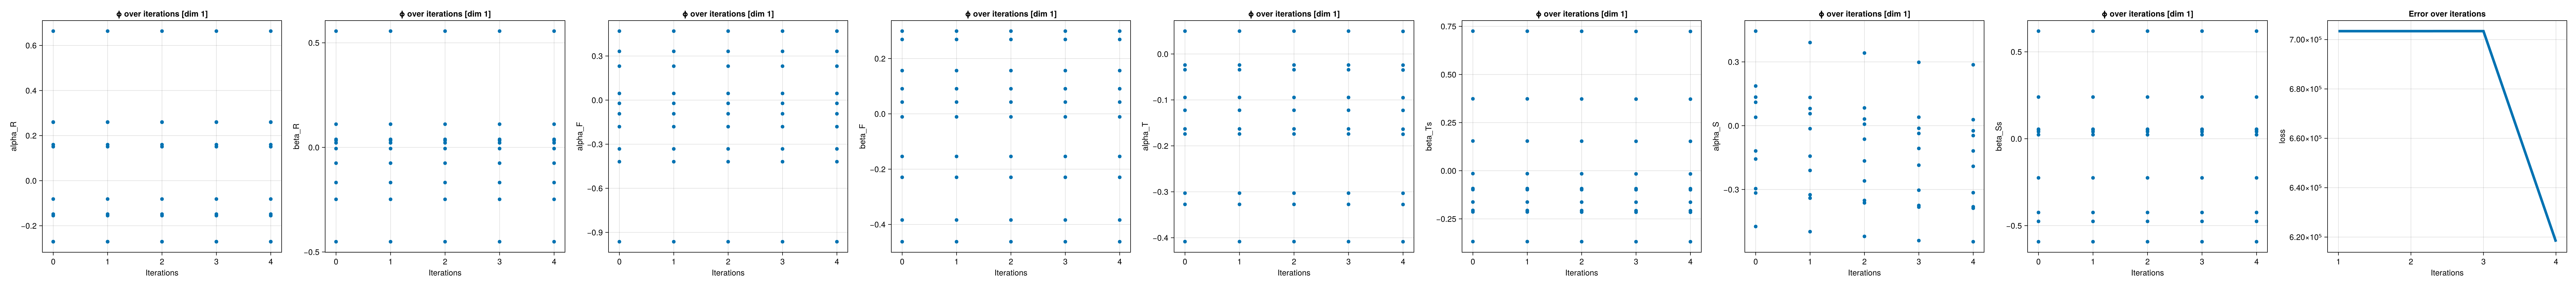

In [5]:
# ---------------- Results Analysis and Visualization ----------------


# θ̂ = EKP.get_ϕ_mean_final(prior, ensemble_kalman_process)
# Γ̂ = unpack_params(θ̂)
# ŷ = model(θ̂)
# rmse = sqrt(mean((ŷ .- observations).^2))

# println("\n=== RESULT: OWUS (CWD-only, static) EKP vs tower LE ===")
# println("Site=$(site_ID)  Period=$(start_date)→$(stop_date)")
# @printf "Γ̂ (α0=%.3f, αC=%.3f,  a0=%.3f, aC=%.3f,  b0=%.3f, bC=%.3f)\n" Γ̂.γα0,Γ̂.γαC,Γ̂.γa0,Γ̂.γaC,Γ̂.γb0,Γ̂.γbC
# @printf "RMSE(diurnal LE) = %.2f W m^-2\n" rmse


# plot
dim_size = sum(length.(EKP.batch(prior)))
fig = CairoMakie.Figure(size = ((dim_size + 1) * 500, 500))

for i in 1:dim_size
    EKP.Visualize.plot_ϕ_over_iters(
        fig[1, i],
        ensemble_kalman_process,
        prior,
        i,
    )
end

EKP.Visualize.plot_error_over_iters(
    fig[1, dim_size + 1],
    ensemble_kalman_process,
)
CairoMakie.save("constrained_params_and_error.png", fig)
fig

In [16]:
sum(length.(EKP.batch(prior)))

8

In [25]:
fig = CairoMakie.Figure(size = (900, 400))

first_G_ensemble = EKP.get_g(ensemble_kalman_process, 1)
last_iter = EKP.get_N_iterations(ensemble_kalman_process)
last_G_ensemble = EKP.get_g(ensemble_kalman_process, last_iter)
n_ens = EKP.get_N_ens(ensemble_kalman_process)

ax = Axis(
    fig[1, 1];
    title = "G ensemble: first vs last iteration (n = $(n_ens), iters 1 vs $(last_iter))",
    xlabel = "Observation index",
    ylabel = "G",
)

Axis with 0 plots:


In [26]:
for g in eachcol(first_G_ensemble)
    lines!(ax, 1:length(g), g; color = (:red, 0.6), linewidth = 1.5)
end

for g in eachcol(last_G_ensemble)
    lines!(ax, 1:length(g), g; color = (:blue, 0.6), linewidth = 1.5)
end

lines!(
    ax,
    1:length(observations),
    observations;
    color = (:black, 0.6),
    linewidth = 3,
)

axislegend(
    ax,
    [
        LineElement(color = :red, linewidth = 2),
        LineElement(color = :blue, linewidth = 2),
        LineElement(color = :black, linewidth = 4),
    ],
    ["First ensemble", "Last ensemble", "Observations"];
    position = :rb,
    framevisible = false,
)

CairoMakie.resize_to_layout!(fig)
CairoMakie.save("obs_G_first_and_last.png", fig);